In [14]:
import numpy as np
from numpy import interp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

In [2]:
# read data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

# get the features and label
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

# encode the label to integers
le = LabelEncoder()
y = le.fit_transform(y)

# check transformed labels
le.classes_  # label transformed to B = 0, M = 1

array(['B', 'M'], dtype=object)

In [3]:
# train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [4]:
# use sklearn pipeline to combine data preprocessing and model training
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression())
pipe_lr.fit(X_train, y_train)

# test set
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.956


# Cross-validation

In [5]:
# stratified k-fold is the most common cross-validation method
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

# keep the accuracy of each k-fold run
scores = []

for k, (train, val) in enumerate(kfold):
    # preprocess and train the model
    pipe_lr.fit(X_train[train], y_train[train])  # the train and val created by kfold are indices, use that to get the samples from the original dataset

    # evaluate the model for this fold on the validation set
    score = pipe_lr.score(X_train[val], y_train[val])
    scores.append(score)


    print(f'Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score:.3f}')

# k-fold accuracy
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} std: {std_acc:.3f}')

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 std: 0.014


In [6]:
# or use sklearn cross_val_score (simpler code), it uses stratified kfold as well
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
# accuracy of each fold
print(f'\nCV accuracy: {scores}')
# accuracy of k-fold
print(f'\nCV accuracy: {np.mean(scores):.3f} std: {np.std(scores):.3f}')


CV accuracy: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

CV accuracy: 0.950 std: 0.014


# Learning Curve

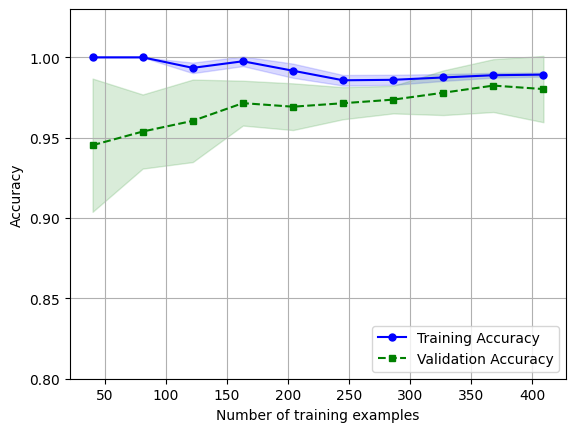

In [7]:
# learning curve shows the training and validation accuracy over the number of training samples, can be used to spot overfitting and underfitting and check how many training samples we need

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter=10000))

# use sklearn learning_curve function to train and cross-validate on different number of training samples
train_sizes, train_scores, val_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)

# get mean and std accuracy of various trainging sample numbers
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# plot training accuracy vs training sample numbers
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

# plot validation accuracy vs training sample numbers
plt.plot(train_sizes, val_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

# Validation Curve

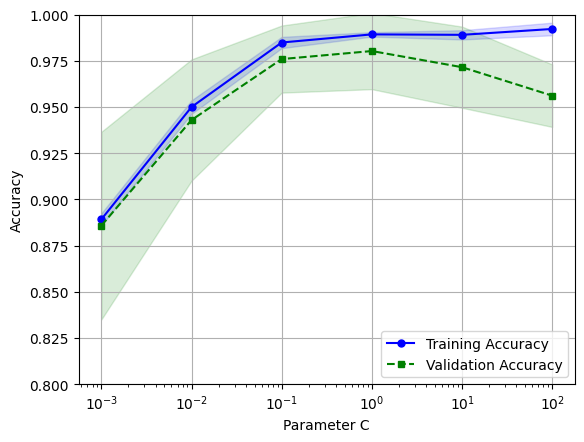

In [8]:
# validation curve is similar to learning curve, but instead of plotting against training number, it plots against model hyperparameter 

# tuning range of the regularization parameter
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# train and cross-val on the C parameter range
train_scores, val_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C', param_range=param_range, cv=10)

# get mean and std accuracy of various trainging sample numbers
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# plot training accuracy vs parameter range
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

# plot validation accuracy vs parameter range
plt.plot(param_range, val_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(param_range, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

# Hyperparameter Tuning

In [9]:
# Grid Search is a popular method for finding the optimal combination of hyperparameter values, it just evaluates every combination and get the optimal

# use SVM (more parameters to tune)
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# tune linear SVM the C parameter, tune rbf kernel SVM the C and gamma parameter
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

# train and eval different configurations of the model to find optimal
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, refit=True, n_jobs=-1)
gs = gs.fit(X_train, y_train)

# get the optimal
print(gs.best_score_)
print(gs.best_params_)

# use the best tuned model on the test set
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.974


In [10]:
# another method is randomized search, which evaluates parameter combinations from a distribution

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc, param_distributions=param_grid, scoring='accuracy', refit=True, n_iter=20, cv=10, random_state=1, n_jobs=-1)
rs = rs.fit(X_train, y_train)

print(rs.best_score_)
print(rs.best_params_)

0.9737681159420291
{'svc__kernel': 'rbf', 'svc__gamma': 0.001, 'svc__C': 10.0}


In [11]:
# another method is halving random search (or grid search), which trains a large sample of hyperparameter configs, train with limited training samples
# then only select some of the better configs, then continue the process with more training samples
hs = HalvingRandomSearchCV(pipe_svc, param_distributions=param_grid, n_candidates='exhaust', resource='n_samples', factor=1.5, random_state=1, n_jobs=-1)
hs = hs.fit(X_train, y_train)

print(hs.best_score_)
print(hs.best_params_)

clf = hs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

0.9676470588235293
{'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100.0}
Test accuracy: 0.965


# Eva;uation Metrics

[[71  1]
 [ 2 40]]


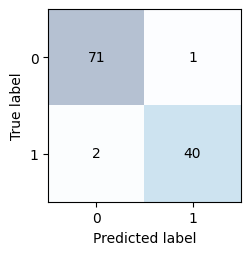

In [12]:
# confusion matrix shows TP, FN, TN, FP

# predict on the test set in order to construct confusion matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

# confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

# plot it
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [13]:
# precision is how much of the predicted as true class, are actually true class, i.e. TP / (TP + FP)
pre_val = precision_score(y_true=y_test, y_pred=y_pred)
print(f'Precision: {pre_val:.3f}')

# rec is how much of the true class are predicted as true, i.e. TP / (TP + FN)
rec_val = recall_score(y_true=y_test, y_pred=y_pred)
print(f'Recall: {rec_val:.3f}')

# f1 score is mean of the two, i.e 2 * (pre x rec) / (pre + rec)
f1_val = f1_score(y_true=y_test, y_pred=y_pred)
print(f'F1: {f1_val:.3f}')

# MCC takes into account all of the confusion matrix, and is usually better metric
mcc_val = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964
MCC: 0.943
